파이썬 머신러닝 완벽가이드 개정2판 ch9 p.601-613

## 05. 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 장르 속성을 이용한 영화 콘텐츠 기반 필터링
- 콘텐츠 기반 필터링: 사용자가 특정 영화를 좋아했을 때, 그 영화와 비슷한 특성/속성, 구성요소를 가진 다른 영화를 추천하는 것
- 영화간 유사성 판단 기준: 영화 구성하는 콘텐츠기반 (장르, 감독, 배우, 평점, 키워드, 영화 설명)

-> 영화 장르 속성 기반 콘텐츠 기반 필터링 추천 시스템: 장르 칼럼값의 유사도 비교 후 그 중 높은 평점 가지는 영화 추천

### 데이터 로딩 및 가공

In [5]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


- 주요 칼럼만 추출: 영화 제목, 장르, 평균 평점, 평점 투표수, 영화 인기도, 영화 설명 주요 키워드, 영화 개요 설명

In [9]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count',
                   'popularity','keywords', 'overview' ]]

In [10]:
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


- 딕셔너리로 된 데이터 가공
    - 개별 장르 명칭 추출: 키 'name' 이용하여 추출
    - ast모듈의 literal_eval() 함수

In [11]:
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

In [12]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x:[ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


### 장르 콘텐츠 유사도 측정
- 여러개의 개별 장르 리스트의 장르별 유사도 측정방법: genres를 문자열로 변경한 뒤, CountVectorizer로 피처벡터화한 행렬 데이터 값을 코사인 유사도로 비교
    1. 문자열로 변환된 genres 칼럼 → count기반으로 피처 벡터화 변환
    2. 피처벡터화 행렬로 변환한 데이터세트를 코사인 유사도를 통해 비교 → 레코드별 타 레코드와 장르에서 코사인 유사도 값 가지는 객체 생성
    3. 장르 유사도가 높은 영화 중 평점 높은 순으로 영화 추천

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

#CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환.
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=1, ngram_range=(1, 2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


- 코사인 유사도 계산: cosine_similarity()


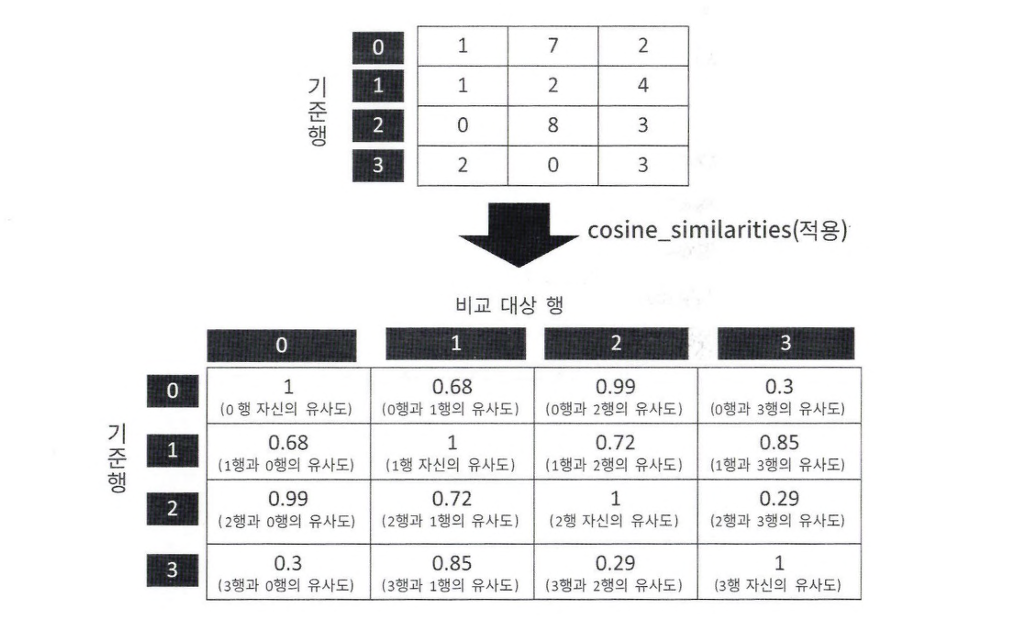

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


- genre_sim 객체의 기준 행별로 비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬된 행렬의 위치 인덱스 추출 → 각 레코드 장르 코사인 유사도가 가장 높은 순으로 정렬된 타 레코드의 위치 인덱스 값을 가짐

In [16]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


### 장르 콘텐츠 필터링을 이용한 영화 추천

In [21]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    # 인자로 입력된 movies_df DataFrame에서 'title'칼럼이 입력된 title_name 값인 DataFrame 추출
    title_movie = df[df['title']==title_name]

    # title_name을 가진 DataFrame의 index 객체를 ndarray로 반환하고
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]

    # 추출된 top_n index 출력, top_n index는 2차원 데이터임.
    # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)

    return df.iloc[similar_indexes]

- 영화 '대부'와 장르별로 유사한 영화 10개 추천: find_sim_movie() 이용

In [22]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


- 많은 후보군 선정한 뒤, 영화의 평점에 따라 필터링해서 최종 추천하는 방식으로 변경 → 'vote_average'값 이용

In [23]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average',
                                                               ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


-> 명작에 비해 이름 들어본 적 없는 영화가 평가 횟수가 매우 작고, 높은 평점으로 되어있는 왜곡된 평점 데이터를 회피할수 있도록 평점에 평가횟수를 반영하는 새로운 평가방식 필요  
-> 평가에 가중치 부여

#### `가중평점(Weighted Rating) = (v/(v+m)) * R + (m/(v+m)) * c`

    - v: 개별 영화에 평점을 투표한 횟수
    - a: 평점을 부여하기 위한 최소 투표 횟수
    - R: 개별 영화에 대한 평균 평점
    - C: 전체 영화에 대한 평균 평점



In [24]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


- 기존 평점을 새로운 가중 평점으로 변경하는 함수 생성- weighted_vote_average()  
: DataFrame의 레코드를 인자로 받아 이 레코드의 vote_count와 vote_average칼럼, 미리 추출된 m과 C값을 적용해 레코드별 가중 평점 반환


In [25]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']

    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis = 1)

In [26]:
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values(
    'weighted_vote', ascending = False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


- 새로운 평점 기준에 따라 영화 추천  
: 장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선정한 뒤에 weighted_vote 칼럼 값이 높은 순으로 top_n만큼 추출

In [27]:
def find_sim_movie(df, sorted_ind, title_name, top_n = 10):
    title_movie = df[df['title']== title_name]
    title_index = title_movie.index.values

    # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
    # 기준 영화 인덱스는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]

    # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending = False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
